# Udacity CarND Term1 Proj3 Behavioral Cloning
* Joe Zhou
* ibalpowr@gmail.com

In [1]:
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

import random

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import MaxPooling2D, Lambda, Cropping2D
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Convolution2D
from keras.optimizers import Adam

Using TensorFlow backend.


# 1st - load the datasets
* default dataset provided by udacity
    * /items/machine_learning-datasets/carnd-term1-project3/
        * driving_log.csv
        * IMG/
            * 24108 images = 8036 * 3
* recovery dataset collected by me
    * /items/machine_learning-datasets/carnd-term1-project3/recovery_new
        * driving_log.cvs
        * IMG/
            * 6591 images = 2197 * 3

In [2]:
cd /items/machine_learning-datasets/carnd-term1-project3

/items/machine_learning-datasets/carnd-term1-project3


In [3]:
log_udacity = pd.read_csv('driving_log.csv')

In [4]:
log_udacity.shape

(8036, 7)

In [5]:
log_udacity.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [6]:
print(log_udacity[:1])

                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   

                                    right  steering  throttle  brake     speed  
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0  22.14829  


In [7]:
# Load recovery Data
log_recovery = pd.read_csv('recovery_new/driving_log.csv')

In [8]:
log_recovery.shape

(2197, 7)

In [9]:
log_recovery.columns

Index(['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed'], dtype='object')

In [10]:
print(log_recovery[:1])

                                              center  \
0  recovery_new/IMG/center_2017_08_22_10_11_12_01...   

                                                left  \
0  recovery_new/IMG/left_2017_08_22_10_11_12_018.jpg   

                                               right  steering  throttle  \
0  recovery_new/IMG/right_2017_08_22_10_11_12_018...       0.0       0.0   

   brake     speed  
0      0  0.000003  


# 2nd - explore the datasets

### check single image
* watch out the space in log entry

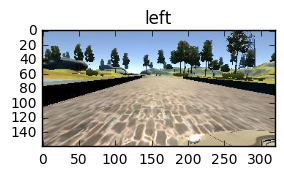

In [11]:
# strip() to remove blank spacings
left0000_udacity = mpimg.imread(log_udacity["left"][0].strip())
fig = plt.figure(figsize=(3,2))
plt.title(log_udacity.columns[1])
plt.imshow(left0000_udacity)
plt.show()

In [12]:
height, width, depth = left0000_udacity.shape
print('image height: ', height)
print('image width: ', width)
print('image depth: ', depth)

image height:  160
image width:  320
image depth:  3


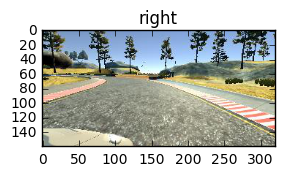

In [13]:
right0000_recovery = mpimg.imread(log_recovery["right"][0].strip())
fig = plt.figure(figsize=(3,2))
plt.title(log_udacity.columns[2])
plt.imshow(right0000_recovery)
plt.show()

### check left, center, right camera images
* on three random time stamps

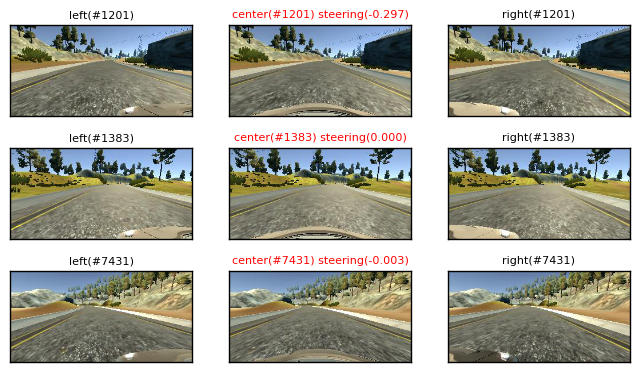

In [14]:
rnd_idx = random.sample(range(0, len(log_udacity)),3)
fig = plt.figure(figsize = (8,4.5))
for i in range(3):
    axis = fig.add_subplot(3,3,i*3+1,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_udacity["left"][rnd_idx[i]].strip()))
    axis.set_title('left(#%i)' %rnd_idx[i], fontsize=8)   
    axis = fig.add_subplot(3,3,i*3+2,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_udacity["center"][rnd_idx[i]].strip()))
    axis.set_title('center(#{idx:d}) steering({angle:.3f})'.format(
            idx=rnd_idx[i], angle=log_udacity['steering'][rnd_idx[i]]), 
                   fontsize=8, color='red')
    axis = fig.add_subplot(3,3,i*3+3,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_udacity["right"][rnd_idx[i]].strip()))
    axis.set_title('right(#%i)' %rnd_idx[i], fontsize=8)

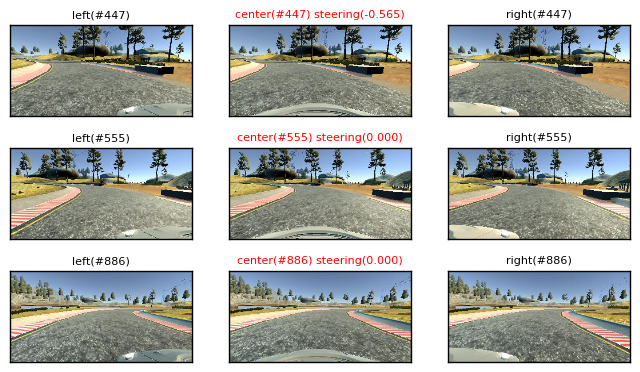

In [15]:
rnd_idx = random.sample(range(0, len(log_recovery)),3)
fig = plt.figure(figsize = (8,4.5))
for i in range(3):
    axis = fig.add_subplot(3,3,i*3+1,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_recovery["left"][rnd_idx[i]].strip()))
    axis.set_title('left(#%i)' %rnd_idx[i], fontsize=8)   
    axis = fig.add_subplot(3,3,i*3+2,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_recovery["center"][rnd_idx[i]].strip()))
    axis.set_title('center(#{idx:d}) steering({angle:.3f})'.format(
            idx=rnd_idx[i], angle=log_recovery['steering'][rnd_idx[i]]), 
                   fontsize=8, color='red')
    axis = fig.add_subplot(3,3,i*3+3,xticks=[],yticks=[])
    axis.imshow(mpimg.imread(log_recovery["right"][rnd_idx[i]].strip()))
    axis.set_title('right(#%i)' %rnd_idx[i], fontsize=8)

### check steering angle's histogram
* steering range [-1.0, 1.0]
* negative == left turn
* positive == right turn
* 0 == straight

<function matplotlib.pyplot.show>

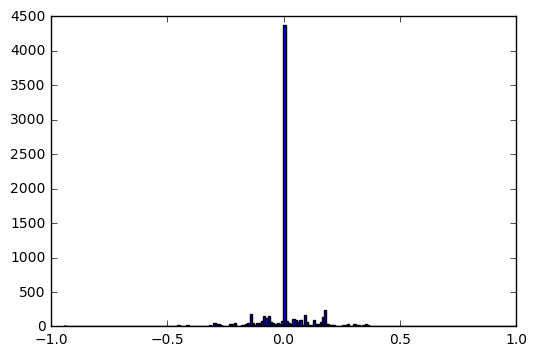

In [16]:
# 2/2000 = 0.01 resolution
plt.hist(log_udacity["steering"],bins=200)
plt.show

<function matplotlib.pyplot.show>

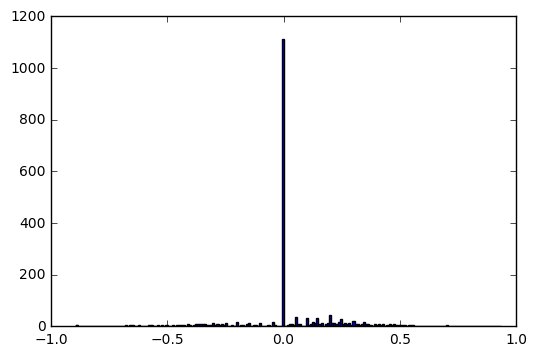

In [17]:
plt.hist(log_recovery["steering"],bins=200)
plt.show

### check number of time stamps nonzero steerings

In [18]:
steering_nonzero = log_udacity["steering"].nonzero()

In [19]:
print('nonzero steering angles in udacity dataset: ')
print(len(steering_nonzero[0]), ' out of ', len(log_udacity))

nonzero steering angles in udacity dataset: 
3675  out of  8036


In [20]:
steering_nonzero_recovery = log_recovery["steering"].nonzero()

In [21]:
print('nonzero steering angles in recovery dataset: ')
print(len(steering_nonzero_recovery[0]), ' out of ', len(log_recovery))
# left: 399 + right: 687 = 1086

nonzero steering angles in recovery dataset: 
1086  out of  2197


In [22]:
log_recovery['steering'].max()

0.93602340000000006

In [23]:
log_recovery['steering'].min()

-0.89187689999999997

### check steering's time series

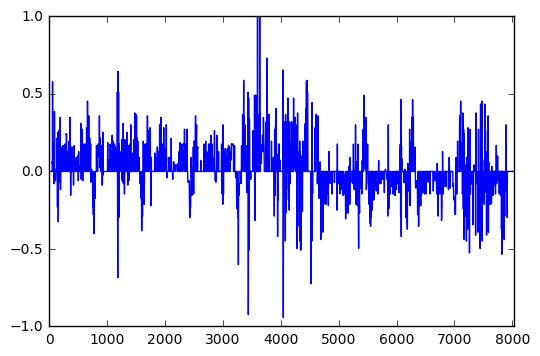

In [24]:
log_udacity["steering"].plot()

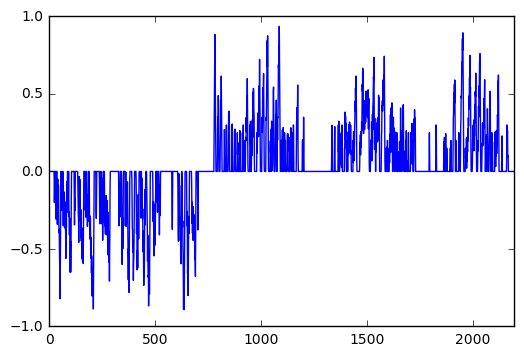

In [25]:
log_recovery["steering"].plot()

### check throttle/brake/speed
* default values: full throttle (= 1.0), no brake (= 0.0), full speed (= 30)

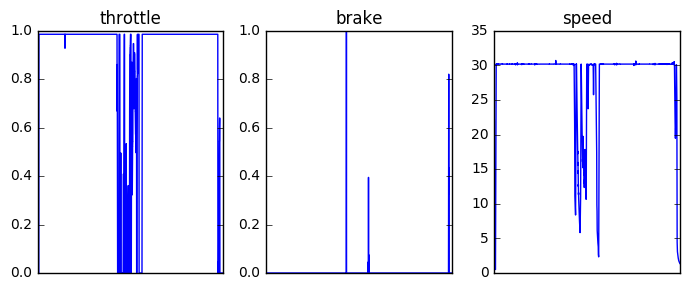

In [26]:
fig=plt.figure(figsize=(7,3))
plt.subplot(1,3,1)
plt.title(log_udacity.columns[4])
log_udacity["throttle"].plot(xticks=[])
plt.subplot(1,3,2)
plt.title(log_udacity.columns[5])
log_udacity["brake"].plot(xticks=[])
plt.subplot(1,3,3)
plt.title(log_udacity.columns[6])
log_udacity["speed"].plot(xticks=[])
plt.tight_layout()

# 3rd - create a new dataset
* remove all 0.0 steering in log_recovery

In [27]:
left, center, right = [], [], []

In [28]:
# go thru each time stamps in udacity dataset
for i in range(len(log_udacity)):
    left_img = log_udacity["left"][i]
    center_img = log_udacity["center"][i]
    right_img = log_udacity["right"][i]
    steering = log_udacity["steering"][i]
    
    # positive means right steering
    if (steering > 0.0):
        right.append([center_img, left_img, right_img, steering])
            
    # negative means left steering
    elif (steering < 0.0):
        left.append([center_img, left_img, right_img, steering])
            
    else:
        if (steering == 0.0):
            center.append([center_img, left_img, right_img, steering])

In [29]:
len(left), len(right), len(center)

(1775, 1900, 4361)

In [30]:
# go thru each time stamps in recovery dataset
for i in range(len(log_recovery)):
    left_img = log_recovery["left"][i]
    center_img = log_recovery["center"][i]
    right_img = log_recovery["right"][i]
    steering = log_recovery["steering"][i]
    
    # positive means right steering
    if (steering > 0.0):
        right.append([center_img, left_img, right_img, steering])
            
    # negative means left steering
    elif (steering < 0.0):
        left.append([center_img, left_img, right_img, steering])
            
    else:
        # drop all 0.0 steerings
        if (steering == 0.0):
            None

In [31]:
len(left), len(right), len(center)

(2174, 2587, 4361)

In [32]:
len(left)+len(right)+len(center)
# center unchanged as 4361
# left: 1775 + 399 = 2174
# right: 1900 + 687 = 2587

9122

### convert to data frame

In [33]:
df_all = pd.DataFrame(left+center+right, \
                      columns=['center','left','right','steering'])

In [34]:
df_all.shape

(9122, 4)

### regroup into a new dataset

In [35]:
X_data = df_all[["center","left","right","steering"]]
y_data = df_all["steering"]

In [36]:
y_data.shape

(9122,)

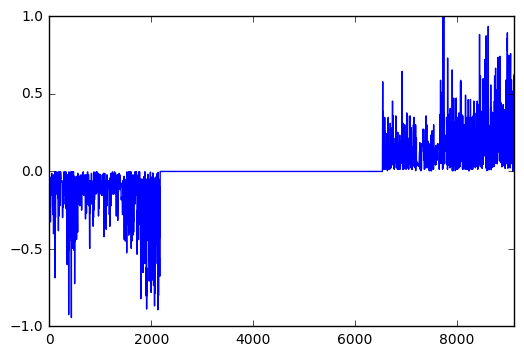

In [37]:
X_data["steering"].plot()

### split into training and validation sets randomly
* 20% for validation

In [38]:
X_train_data, X_valid_data, y_train_data, y_valid_data = \
                train_test_split(X_data, y_data, test_size=0.2)

In [39]:
# reset the index
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)

In [40]:
type(X_train_data)

pandas.core.frame.DataFrame

In [41]:
X_train_data.shape

(7297, 4)

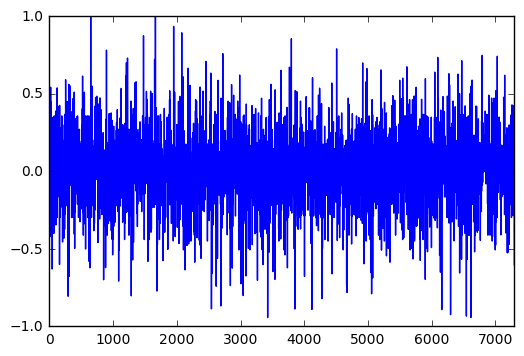

In [42]:
X_train_data["steering"].plot()

In [43]:
X_valid_data.shape

(1825, 4)

# 4th - preprocess datasets

### change the brightness of an image
* use V channel from H(ue) S(aturation) V(alue)
    * RGB is not additive
* lower V value == darker
    * for tree shadow

In [44]:
# value aka brightness ... [0,1]
def set_darker(image):

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * random.uniform(0.7, 1)
    #hsv[:,:,2] = hsv[:,:,2] * 0.7

    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

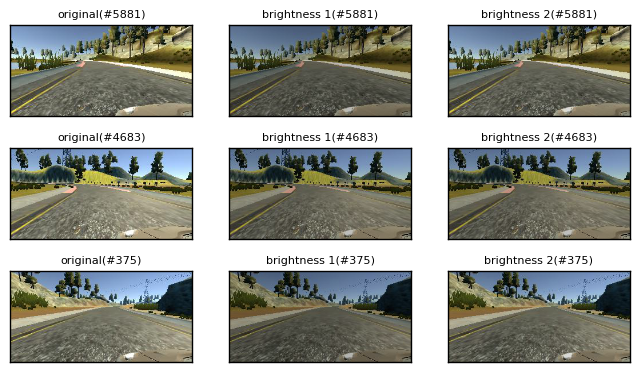

In [45]:
random_idx = random.sample(range(0, len(log_udacity)),3)
fig = plt.figure(figsize = (8,4.5))
for i in range(3):
    img = mpimg.imread(log_udacity["left"][random_idx[i]].strip())
    axis = fig.add_subplot(3,3,i*3+1,xticks=[],yticks=[])
    axis.imshow(img)
    axis.set_title('original(#%i)' %random_idx[i], fontsize=8)   
    axis = fig.add_subplot(3,3,i*3+2,xticks=[],yticks=[])
    axis.imshow(set_darker(img))
    axis.set_title('brightness 1(#%i)' %random_idx[i], fontsize=8)   
    axis = fig.add_subplot(3,3,i*3+3,xticks=[],yticks=[])
    axis.imshow(set_darker(img))
    axis.set_title('brightness 2(#%i)' %random_idx[i], fontsize=8)

### flip an image
* vertically

In [46]:
# 1 mean along y axis ... vertically
# 0 mean along x axis ... horizontally
def flip_along_y_axis(image,steering):       
    return cv2.flip(image,1), -steering

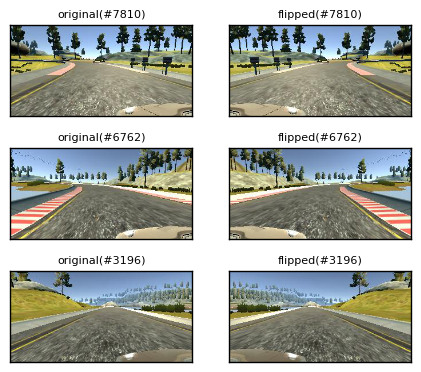

In [47]:
random_idx = random.sample(range(0, len(log_udacity)),3)
fig = plt.figure(figsize = (8,4.5))
for i in range(3):
    img = mpimg.imread(log_udacity["left"][random_idx[i]].strip())
    steering = log_udacity["steering"][random_idx[i]]
    axis = fig.add_subplot(3,3,i*3+1,xticks=[],yticks=[])
    axis.imshow(img)
    axis.set_title('original(#%i)' %random_idx[i], fontsize=8)   
    axis = fig.add_subplot(3,3,i*3+2,xticks=[],yticks=[])
    img_flipped, _ = flip_along_y_axis(img,steering)
    axis.imshow(img_flipped)
    axis.set_title('flipped(#%i)' %random_idx[i], fontsize=8)   

### define a crop function 
* input shape for nvidia model: 66x200x3

In [48]:
nvidia_height = 66
nvidia_width = 220

In [49]:
def crop_image(image):

    start = int(image.shape[0] * 0.35)
    end = int(image.shape[0] * 0.875)   
    
    # removes the sky on the top
    # and the hood on the bottom
    new_image = image[start:end, :]
    
    # resizes to 66 x 220 for nvidia model
    new_image = cv2.resize(new_image, (nvidia_width,nvidia_height), \
                           interpolation=cv2.INTER_AREA)
    
    return new_image

### define preprocessing functions
* darker, crop, flip
* use only "center" image
* only crop in validation

In [50]:
def preprocess_image_train(data_row_df):

    image = mpimg.imread(data_row_df["center"][0])
    steering = data_row_df["steering"][0]
    
    image = set_darker(image)
    
    # flip half of the images
    if np.random.randint(2) == 1:
        image, steering = flip_along_y_axis(image,steering)
    
    image = crop_image(image)

    return np.array(image), steering

In [51]:
def preprocess_image_valid(data_row_df):

    image = mpimg.imread(data_row_df["center"][0])   
    steering = data_row_df['steering'][0]
    
    image = crop_image(image)
    
    return np.array(image), steering

# 5th - define generator

In [52]:
def generate_batch_train_from_dataframe(data_df, batch_size):
    
    batch_images = np.zeros((batch_size, nvidia_height, \
                             nvidia_width, depth))
    batch_steerings = np.zeros(batch_size)
    
    while True:
        for i in range (batch_size):

            idx = np.random.randint(len(data_df))
            data_row = data_df.iloc[[idx]].reset_index()

            # preprocess image and steering
            img, steering = preprocess_image_train(data_row)

            batch_images[i] = img
            batch_steerings[i] = steering

        yield batch_images, batch_steerings

In [53]:
def generate_valid_from_dataframe(data_df):
    while True:
        for idx in range(len(data_df)):
            
            data_row = data_df.iloc[[idx]].reset_index()
            
            # preprocess image and steering
            img, steering = preprocess_image_valid(data_row)

            # reshape to (1, height, width, channel)
            # before feeding to the model
            img = img.reshape(1, img.shape[0], \
                              img.shape[1], img.shape[2])
            steering = np.array([[steering]])
            yield img, steering

### test the generator

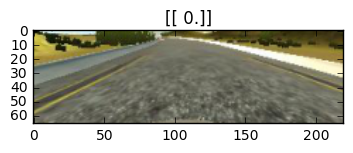

In [54]:
# initialize generator
valid_data_generator = generate_valid_from_dataframe(X_valid_data)

# display a test image
for i in range(100):
    next(valid_data_generator)

plt.figure(figsize=(4, 3))    
img, steering = next(valid_data_generator)
plt.imshow(img[0])
plt.title(str(steering))

# 6th - define convnet model
* inspired by VGG16
* 3 layers of convolution + 4 layers of fully-connected

In [55]:
input_shape = (nvidia_height, nvidia_width, depth)

In [56]:
def get_model():
    
    model = Sequential()
    
    # normalize to [-0.5, 0.5]
    model.add(Lambda(lambda x: x/255.0 - 0.5, input_shape = input_shape))
    
    # convolution + maxpooling
        # filter size 3x3
        # subsample is stride
        # valid means 0 padding
        # pool size 2
    #1
    model.add(Convolution2D(16, 3, 3, subsample=(1, 1), \
                border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    #2
    model.add(Convolution2D(36, 3, 3, subsample=(1, 1), \
                border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    #3
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), \
                border_mode='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    
    # fully-connected layers
    model.add(Dense(512, activation='relu'))
       
    model.add(Dense(128, activation='relu'))
    
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))

    # learning rate 1e-4
    # value function: mse
    # optimizer: adam
    model.compile(optimizer=Adam(lr=1e-4), loss='mse')
    
    return model

# 7th - training

In [57]:
train_samples = len(X_train_data)
validation_samples = len(X_valid_data)
epoch = 4

batch = 256

In [58]:
for idx in range(3):
    print("iteration: ", idx)    
    train_data_generator = generate_batch_train_from_dataframe\
                    (X_train_data, batch)

    # initialize generator
    #valid_data_generator = generate_valid_from_dataframe\
    #                (X_valid_data)
    
    model = get_model()
    model.fit_generator(train_data_generator, \
                        samples_per_epoch=train_samples, \
                        nb_epoch=epoch, \
                        validation_data=valid_data_generator, \
                        nb_val_samples=validation_samples)
    
    
    fileWeightsNew = 'model-udacity_recovery-' + str(idx) + '.h5'
    model.save(fileWeightsNew)    

iteration:  0
Epoch 1/4
7168/7297 [============================>.] - ETA: 1s - loss: 0.0201

/ibalpowr/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


7424/7297 [==============================] - 75s - loss: 0.0200 - val_loss: 0.0175
Epoch 2/4
7424/7297 [==============================] - 72s - loss: 0.0135 - val_loss: 0.0163
Epoch 3/4
7424/7297 [==============================] - 72s - loss: 0.0147 - val_loss: 0.0151
Epoch 4/4
7424/7297 [==============================] - 74s - loss: 0.0145 - val_loss: 0.0153
iteration:  1
Epoch 1/4
7424/7297 [==============================] - 74s - loss: 0.0247 - val_loss: 0.0176
Epoch 2/4
7424/7297 [==============================] - 72s - loss: 0.0149 - val_loss: 0.0151
Epoch 3/4
7424/7297 [==============================] - 73s - loss: 0.0132 - val_loss: 0.0144
Epoch 4/4
7424/7297 [==============================] - 73s - loss: 0.0134 - val_loss: 0.0147
iteration:  2
Epoch 1/4
7424/7297 [==============================] - 74s - loss: 0.0228 - val_loss: 0.0187
Epoch 2/4
7424/7297 [==============================] - 73s - loss: 0.0160 - val_loss: 0.0158
Epoch 3/4
7424/7297 [==============================]